## How to - some advice for setting hyperparameters reasonably and troubleshooting

Here we compile a list of practical advice on how to get PILCO to solve a problem. There are several hyperparameters that need to be set in advance, but these in general can be related to aspects of the problem at hand, and a bit of experimenting can help avoid massive hyperparameter searches later on. Additionally, there are a number of things that can go wrong and when this happens, a good first step is figuring out which component is failing. So, we organise the rest around the major components of the framework and we comment on hyperparameter settings and troubleshooting for each one in turn. Starting with some necessary intiialisations below (we go with the Pendulum-v0 task here that doesn't require  mujoco to run):

In [ ]:
import numpy as np
import gym
from pilco.models import PILCO
from pilco.controllers import RbfController, LinearController
from pilco.rewards import ExponentialReward
import tensorflow as tf
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
np.random.seed(0)

from utils import rollout, policy


class myPendulum():
    def __init__(self):
        self.env = gym.make('Pendulum-v0').env
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        high = np.array([np.pi, 1])
        self.env.state = np.random.uniform(low=-high, high=high)
        self.env.state = np.random.uniform(low=0, high=0.01*high) # only difference
        self.env.state[0] += -np.pi
        self.env.last_u = None
        return self.env._get_obs()

    def render(self):
        self.env.render()

        
env = myPendulum()

# Settings, are explained in the rest of the notebook
SUBS=3 # subsampling rate
T = 30 # number of timesteps (for planning, training and testing here)
J = 3 # rollouts before optimisation starts

max_action=2.0 # used by the controller, but really defined by the environment

# Reward function parameters
target = np.array([1.0, 0.0, 0.0])
weights = np.diag([2.0, 2.0, 0.3])

# Environment defined
m_init = np.reshape([-1.0, 0.0, 0.0], (1,3))
S_init = np.diag([0.01, 0.01, 0.01])

### Gaussian Process model
The model is maybe the most crucial component, but its hyperparameters don’t need to be set in advance. Instead hyperparameters used, signal variance, signal noise, and lengthscales are optimised by maximum likelihood, when training the model. It is beneficial sometimes to fix the signal noise, see examples. Also priors can be used, which can have a regularising effect, useful when we see the hyperparameters taking extreme values (lengthscales are especially prone to this with values like $10^5$).

#### Troubleshooting 
Let's collect some data, train pilco, and execute the proposed (optimised) policy:

In [114]:
# Random rollouts
X,Y = rollout(env, None, timesteps=T, verbose=False, random=True, SUBS=SUBS, render=False)
for i in range(1,J):
    X_, Y_ = rollout(env, None, timesteps=T, verbose=False, random=True, SUBS=SUBS, render=False)
    X = np.vstack((X, X_))
    Y = np.vstack((Y, Y_))

state_dim = Y.shape[1]
control_dim = X.shape[1] - state_dim
controller = RbfController(state_dim=state_dim, control_dim=control_dim, num_basis_functions=10, max_action=max_action)
R = ExponentialReward(state_dim=state_dim, t=target, W=weights)
pilco = PILCO(X, Y, controller=controller, horizon=T, reward=R, m_init=m_init, S_init=S_init)

pilco.optimize_models(maxiter=100)
pilco.optimize_policy(maxiter=20)

# Rollout using the pilco controller
X_new, Y_new = rollout(env, pilco, timesteps=T, SUBS=SUBS, render=False)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -397.396152
  Number of iterations: 21
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -397.396152
  Number of iterations: 21
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -392.768716
  Number of iterations: 20
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -392.768716
  Number of iterations: 20
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -389.175807
  Number of iterations: 20
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -389.175807
  Number of iterations: 20
  Number of functions evaluations: 23


-----Learned models------
---Lengthscales---
      GP0     GP1     GP2
0   2.728   2.327   4.876
1   2.333   2.498   4.951
2  11.714  10.863  21.121
3  29.247  25.250  27.294
---Variances---
     GP0    GP1     GP2
0  1.939  1.849  14.903
---Noises---
         GP0        GP1        GP2
0  1.000e-06  1.000e-06  1.000e-06
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -2.330366
  Number of iterations: 20
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -2.330366
  Number of iterations: 20
  Number of functions evaluations: 36


Controller's optimization: done in 44.4 seconds with reward=2.330.
Action:  [-1.80564502]
State :  [-0.99829368  0.05839292 -0.82658769]
Action:  [-1.96259262]
State :  [-0.96911801  0.2465974  -1.45011426]
Action:  [-1.99974217]
State :  [-0.88237508  0.47054673 -1.62584014]
Action:  [-1.99866283]
State :  [-0.75969355  0.65028126 -1.3194338 ]
Action:  [-1.97719704]
State :  [-0.66550305  0.74639513 -0.65935998]
Action:  [-1.87291156]
State :  [-0.65519666  0.75545836  0.19825346]
Action:  [0.50690081]
State :  [-0.80272049  0.59635544  2.04476685]
Action:  [-0.37893302]
State :  [-0.9733883   0.22916198  2.97035075]
Action:  [0.71452082]
State :  [-0.96279998 -0.27021509  3.43916355]
Action:  [1.99400625]
State :  [-0.70085053 -0.71330817  3.36799932]
Action:  [1.99829921]
State :  [-0.34856368 -0.9372851   2.45617762]
Action:  [1.93058819]
State :  [-0.11545371 -0.99331286  1.15729295]
Action:  [0.80110806]
State :  [-0.12948872 -0.99158089 -0.72092128]
Action:  [-0.88141158]
State 

How to know something is wrong:

- By inspection, hyperparameters values can seem implausible (lengthscales > $10^5$).
- Check the one-step predictions "manually":

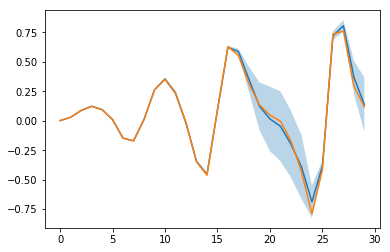

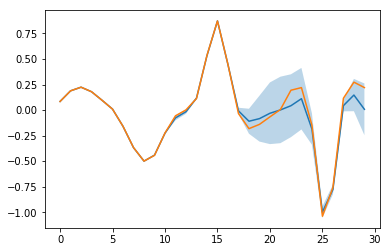

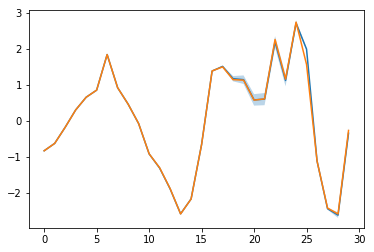

(30, 1)

In [115]:
for i,m in enumerate(pilco.mgpr.models):
    y_pred_test, var_pred_test = m.predict_y(X_new)
    plt.plot(range(len(y_pred_test)), y_pred_test, Y_new[:,i])
    plt.fill_between(range(len(y_pred_test)),
                       y_pred_test[:,0] - 2*np.sqrt(var_pred_test[:, 0]), 
                       y_pred_test[:,0] + 2*np.sqrt(var_pred_test[:, 0]), alpha=0.3)
    plt.show()
    
np.shape(var_pred_test)

- Check multi-step predictions manually:



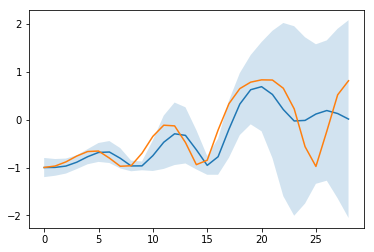

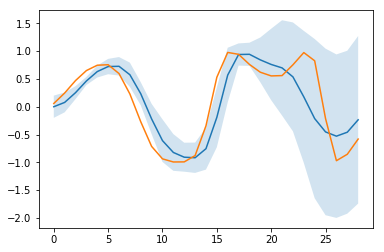

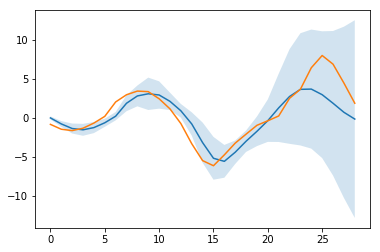

In [116]:
from utils import predict_trajectory_wrapper
m_p = np.zeros((T, state_dim))
S_p = np.zeros((T, state_dim, state_dim))
for h in range(T):
    m_h, S_h, _ = predict_trajectory_wrapper(pilco, m_init, S_init, h)
    m_p[h,:], S_p[h,:,:] = m_h[:], S_h[:,:]
    

for i in range(state_dim):    
    plt.plot(range(T-1), m_p[0:T-1, i], X_new[1:T, i]) # can't use Y_new because it stores differences (Dx)
    plt.fill_between(range(T-1),
                     m_p[0:T-1, i] - 2*np.sqrt(S_p[0:T-1, i, i]),
                     m_p[0:T-1, i] + 2*np.sqrt(S_p[0:T-1, i, i]), alpha=0.2)
    plt.show()
    

If these are reasonably accurate (no need for perfection here), then it's probably not the model's issue.

Possible fixes and examples:

- Collect more data. Try increasing the J parameter, the number of rollouts run before optimising a policy for the first time. If you need 10 runs to get a model that can capture *anything* useful, the first 10 policy optimisation runs are wasted time. On the other hand this is obviously not very data-efficient. Example: both _inverted_ pendulum tasks, since random rollouts tend to be extremely short in there environments.
- If there are numerical errors coming up during optimisation of either the model or the controller, they can often be avoided by increasing the model noise.
- Fixing noise or using priors. As mentioned earlier, priors can be helpful even without expert knowledge, by regularising the model.
- Are there non-smooth dynamics in the system you are trying to model? If so, is modelling them crucial for solving the task? If not it might be beneficial to filter them out. For example, in the inverted double pendulum task, when the pendulum gets in contact with the "walls" limiting the environment, it bounces back. This hurts the model's ability to generalise and is not modelling it is not necessary to solve the task, so we filter it out (see the wrapper used in `inv_double_pendulum.py`).
- Is the state fully observable? Is the reward defined as a function of the state? In the swimmer env the reward is defined on a state that not returned as an observation. To counter this, we augment the state space by an extra variable that is equal to accumulated rewards (which is equal to forward movement minus some penalty for the controls used).
- Pilco is only able to perform unimodal predictions. Is this a reasonable assumption in your case? If not, is it game-breaking or can you work around it? In any pendulum stabilisation scenario, there multiple failure scenarios (the pendulum falling in different directions) but that doesn't hurt pilco's performance. In contrast, in the pendulum swing-up scenario, the original openai environment initialises the pendulum in an arbitrary state (both angle and velocity), and that makes effective planning impossible for pilco (see wrapper in `pendulum_swing_up.py`).

### The reward function

#### Initial Assumptions
PILCO assumes a given a priori reward function, given as an analytic function of the current state $r_t = r(x_t)$. The function form is that of an exponential (and in the swimmer env we introduce a linear r.f. and the possibility of combining reward functions). Can the reward structure of your problem be captured sufficiently with such a function?

#### Hyperparameters 
For the exponential reward function we need to set the target and the weights, which correspond to the centre of the exponential and the sensitivity of the reward to the different dimensions (for most cases we can use a diagonal weight matrix).

For the center of the exponential, it has to be on a state which when the system reaches (or stabilises itself there), the task can be considered sufficiently solved. It can be a set of states, for example when one state space variable corresponds to a radius and another to an angular velocity, by setting a target like [$r_\ast,v_\ast$] and weights $[[1,0],[0,10^{-5}]]$, we practically reward a circular trajectory of radius $r_\ast$.

The weights should take reasonable values between two extremes: 
- high magnitude values make the reward decay faster and make exploration harder (the reward signal becomes sparser)
- low magnitude values can make the reward gradient uninformative, or very small in magnitude, slowing learning down.

State variables that are irrelevant for the current task, should correspond to low value weights to avoid unforeseen consequences. For example, if what we want from the system is to get to a certain position, velocity variables are irrelevant. If we have an arbitrary 0 target for the velocity variable, and the weight is not small, higher velocities will be penalised for no reason, resulting in "optimal" (by reward function standards) behaviours that are slow (usually not what we want).

#### Testing
Check manually rewards for different states by:


In [109]:
from utils import reward_wrapper

m = np.random.rand(state_dim)
s = 0.001 * np.eye(state_dim)
print(reward_wrapper(R, m[None, :], s))

m = target
print(reward_wrapper(R, m[None, :], s))



(array([[0.59107739]]), array([[0.0007131]]))
(array([[0.99785433]]), array([[4.01176548e-06]]))


Can also evaluate whole trajectories using something like:



In [110]:
# assuming X the data corresponding to a trajectory
total_r = 0

for i in range(len(X_new)):
    total_r += reward_wrapper(R, X_new[i,None, 0:3], s)[0]
    
print(total_r)

[[0.50450805]]


In certain cases we found useful printing both the predicted return, based on the predicted trajectory by the model, given the policy and the reward function, and the actual return by running the policy in an episode on the real system:
- Significant disparity between the two points to a problem of the model. 
- If both are practically 0, then the reward function might be too narrow (weights too high)
- If the reward is high, but the trajectory doesn't seem to solve the task, some other reward shaping issue (weights too low, targets at the wrong place, state variables correspond to different things than what is assumed).

### The policy (aka the controller)

The overall goal of the algorithm is to learn a policy that efficiently solves the task at hand. The policy is parametrised and the values of these parameters is exactly what we optimise.

The action space, the available values for the controllers output (which are the system's inputs), usually referred to as $u_t$, are assumed to be in a continuous interval around 0 with a maximum magnitude $max_action$. This value is specific to each environment.

For _linear_ controllers, there aren't any hyperparameters to be set, since all the parameters are learned.

For _rbf_ controllers, the hyperparameter that we need to set is the number of basis functions used. A higher number gives more flexibility, and might also alleviate problems related to local minima (see restarts), while it increases computational demands.

### Misc
#### Restarts
Since the GP model's hyperparameters and the controller's parameters are trained with gradient based iterative algorithms, in generally non-convex settings, they can be stuck in local minima. Restarts can help deal with these issues, and we recommend experimenting with them, especially when performance fluctuates a lot between runs.

#### Subsampling
We have introduced a subsampling parameter, that did not existed in the original algorithm. We did so because, unlike thre original implementation, we are solving scenarios that were pre-existing and the granularity of the timesteps don't always fit PILCO. For example, a long time horizon, (300 steps), when only very small differences are observed between consecutive states, makes planning unecessary hard, since predictions have to be performed iteratively, with errors and uncertainty compounded. By subsampling, using one of 5 samples, and repeating the same action for the rest, allows to deal with the same task on a much more manageable horizon of 60. Of course, the same action is repeated 5 times, so the control we apply is less fine tuned (alternatively, the system appears more stiff). We think this a reasonable trade off, since a task that requires precise, high frequency control over a long time horizon, can be fairly considered as hard task and it's reasonable for any algorithm to find it more challenging.

#### Initial conditions
PILCO takes in a mean and variance for the initial state of the task. Since planning is based on normally distributed and thus unimodal predictions, if the variance is very high (random initialisation anywhere in the eligible state space for example), PILCO can't use its model to learn. This was the case for the pendulum task (pendulum swing up), and when we fixed the initial state, PILCO solved the problem successfully.


#### Horizon - planning, training, testing

Another important component is the number of timesteps that's used for the different components of the algorithm.
These can be assumed and a lot of times are the same but that is not necessary.

For planning, we set the number of time steps for which we plan using the model. It is set when the pilco object is first constructed. We want this to be long enough for PILCO to guide the system to the target state, but an overly long planning horizon can introduce unnecessary noise, increase computational burden for no reason, and cause memory issues. We should about the planning horizon along with the subsampling variable.

By training horizon we refer to the number of time steps per episode, that are used for the training of the GP model. Should be greater or equal than the corresponding planning horizon. Too short and data (and information) is wasted, too long and computational demands increase without real benefit.

For the testing horizon, we usually refer to tasks where the system needs to be stabilised to certain state and not just reach it. In these cases it might make sense to have a much larger testing horizon, to make sure the policy learned is successful in that regard.